In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 18

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_pv = pd.read_hdf('./Data/Crypto/crypto_min.h5')
df_pv = df_pv.reset_index()
df_pv = df_pv.set_index('time')

df_pv['id'].unique()

array(['BTC-USD', 'ETH-USD', 'SOL-USD', 'AVAX-USD', 'ADA-USD'],
      dtype=object)

In [75]:
def construct_signal(df_pv, coin1='SOL-USD', coin2='ETH-USD'):
    df = df_pv[df_pv.id==coin1][['close']].join(df_pv[df_pv.id==coin2][['close']], rsuffix='2')

    df['ratio'] = (df['close']/df['close2'])[df.index.normalize().unique()[1:]]
    df = df.fillna(method='ffill').dropna()
    df['spread'] = df['close'] - df['ratio'] * df['close2']

    df['signal'] = df['spread'].ewm(span=2).mean() - df['spread'].ewm(span=30).mean()
    
    plt.figure(figsize=(14,8))
    df['signal'].plot()
    plt.title(f"ema signal of {coin1} and {coin2}")

    return df[['close', 'close2', 'ratio', 'spread', 'signal']]

In [243]:
def pnl_test(df, coin1='SOL', coin2='ETH', stacks=[0.01, 0.015, 0.02], notional=30_000, cost = 6e-4, timecap=600):
    start_old = df.index[0]
    convergence_old = df.index[0]

    open_times = df.index[(abs(df['signal']) > stacks[0] * df.close).astype(int).diff() == 1]
    no_trade_times = df.between_time('23:00:00', '01:00:00').index
    res = pd.DataFrame()


    for start in open_times:
        if start in no_trade_times or (start - start_old).total_seconds() <= 65 or start < convergence_old:
            continue
        
        flag = np.sign(df.loc[start, 'signal'])
        idx = df.loc[start:].index
        converge_t = min(idx[(df.loc[start:, 'signal'] * flag <0).argmax()], start + timedelta(minutes=timecap))

        start_old = start
        convergence_old = converge_t

        for stack in stacks:
            if not (df.loc[start:converge_t, 'signal'] * flag > stack * df.loc[start:converge_t, 'close']).any():
                continue

            start_ = idx[(df.loc[start:converge_t, 'signal'] * flag > stack * df.loc[start:converge_t, 'close']).argmax()]

            new_idx = df.loc[start_:converge_t].index
            bottom_t = new_idx[(df.loc[start_:converge_t, 'signal'].diff() * flag < 0).argmax()]

            coin1mk = -1 * flag * notional / df.loc[start_, 'close'] * (df.loc[converge_t,'close'] - df.loc[start_, 'close']) - notional * cost
            coin2mk = flag * notional / df.loc[start_, 'close2'] * (df.loc[converge_t,'close2'] - df.loc[start_, 'close2']) - notional * cost
            hgmk = coin1mk + coin2mk

            bc_hgmk = -1 * flag * notional * \
                    ((df.loc[converge_t,'close'] - df.loc[bottom_t, 'close'])/df.loc[bottom_t, 'close'] - \
                    (df.loc[converge_t,'close2'] - df.loc[bottom_t, 'close2'])/df.loc[bottom_t, 'close2']) - 2 * notional * cost

            res=res.append(pd.Series([start, start_, coin1mk, coin2mk, hgmk, bc_hgmk, converge_t, bottom_t, stack, flag]), ignore_index=True)


    res.columns=['start', 'start_stack', 'coin1mk', 'coin2mk',   'bc_hgmk', 'hgmk','converge_t', 'bottom', 'stack', 'flag']

    res.set_index('start_stack')[['hgmk', 'bc_hgmk']].cumsum().plot()
    plt.title(f'Cumulative Pnl of {coin1}-{coin2}')
    plt.show()

    res.hgmk.hist()
    plt.title(f'histogram of PnL per trade of {coin1}-{coin2}')
    plt.show()

    print("--------------- value counts")
    print(res['flag'].value_counts())
    print("--------------- total mean")
    print(res.mean())
    print(f"--------------- mean pnl of buy {coin1} and sell {coin2}")
    print(res[res.flag==-1].mean())
    print(f"--------------- mean pnl of sell {coin1} and buy {coin2}")
    print(res[res.flag==1].mean())
    print("---------------- total tval")
    print(res.mean()/res.std())
    print(f"--------------- tval of buy {coin1} and sell {coin2}")
    print(res[res.flag==-1].mean()/res[res.flag==-1].std())
    print(f"--------------- tval of sell {coin1} and buy {coin2}")
    print(res[res.flag==1].mean()/res[res.flag==1].std())
    print(f"--------------- winning rate")
    print((res['bc_hgmk'] > notional * 10e-4).sum()/res.shape[0])
    print((res['hgmk'] > notional * 10e-4).sum()/res.shape[0])
    print(f"--------------- winning rate buy and sell")
    print((res[res.flag==-1]['hgmk'] > notional * 10e-4).sum()/res[res.flag==-1].shape[0])
    print((res[res.flag==1]['hgmk'] > notional * 10e-4).sum()/res[res.flag==1].shape[0])
    return res

In [212]:
coin1='SOL-USD'
coin2='ETH-USD'

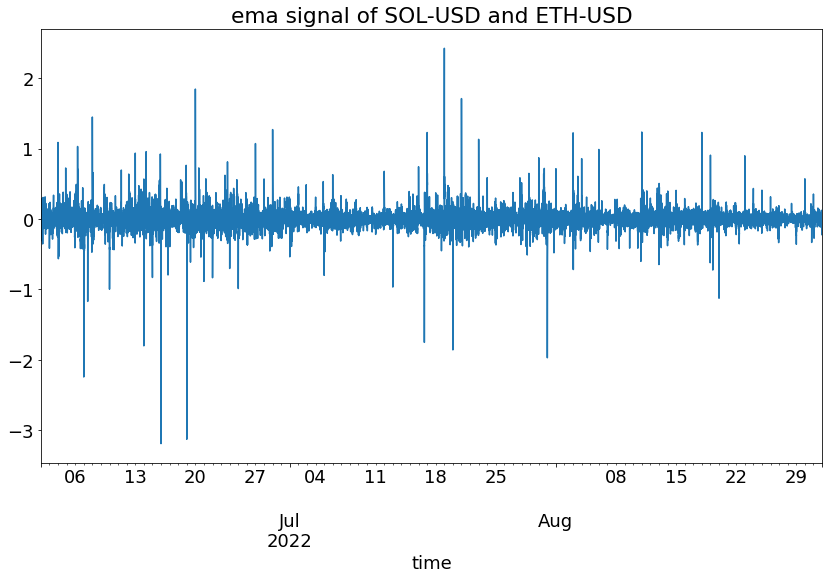

In [241]:
df = construct_signal(df_.loc['2022-06-01':'2022-08-31',:], coin1, coin2)

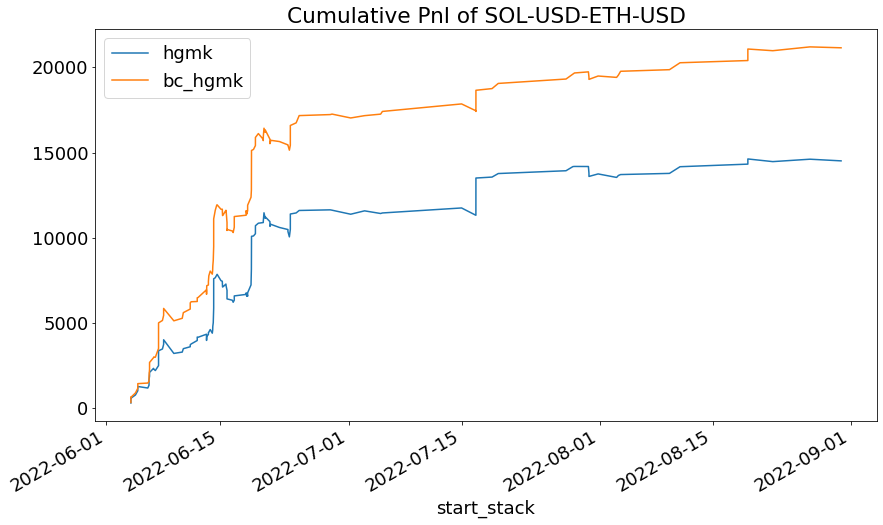

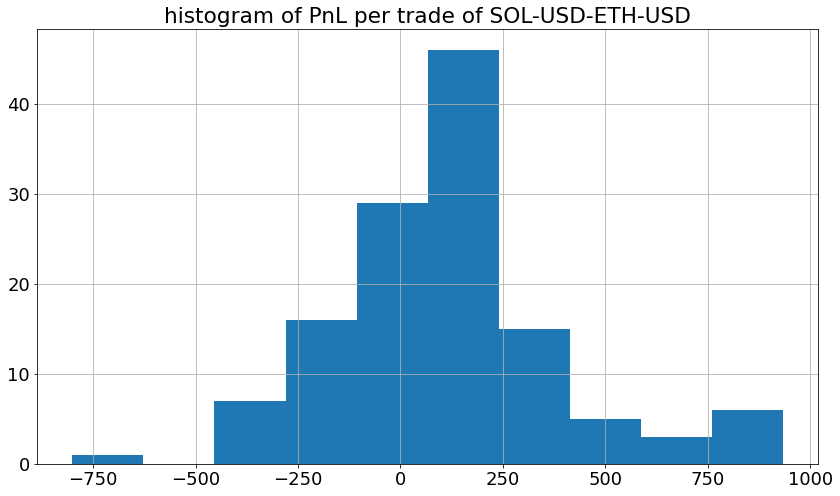

--------------- value counts
 1.0    82
-1.0    46
Name: flag, dtype: int64
--------------- total mean
coin1mk    106.098594
coin2mk     59.111316
bc_hgmk    165.209910
hgmk       113.394864
stack        0.012109
flag         0.281250
dtype: float64
--------------- mean pnl of buy SOL-USD and sell ETH-USD
coin1mk    254.180400
coin2mk    -67.235247
bc_hgmk    186.945154
hgmk       137.503766
stack        0.012500
flag        -1.000000
dtype: float64
--------------- mean pnl of sell SOL-USD and buy ETH-USD
coin1mk     23.028312
coin2mk    129.988656
bc_hgmk    153.016968
hgmk        99.870357
stack        0.011890
flag         1.000000
dtype: float64
---------------- total tval
bc_hgmk        0.536182
bottom              NaN
coin1mk        0.220856
coin2mk        0.124501
converge_t          NaN
flag           0.291933
hgmk           0.393739
stack          3.146955
start               NaN
start_stack         NaN
dtype: object
--------------- tval of buy SOL-USD and sell ETH-USD
bc_hgmk

In [244]:
res = pnl_test(df, coin1=coin1, coin2=coin2, stacks=[0.01, 0.015, 0.02, 0.03], notional=30_000, timecap=600)

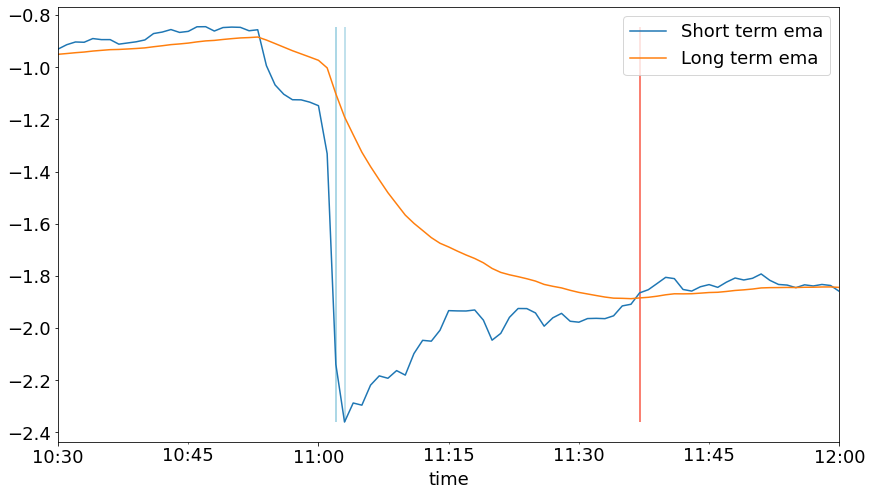

In [224]:
start_time = '2022-06-07 10:30:00'
end_time = '2022-06-07 12:00:00'
fig,ax = plt.subplots(1)

df.spread.ewm(span=2).mean()[start_time:end_time].plot(ax=ax, label='Short term ema')
df.spread.ewm(span=30).mean()[start_time:end_time].plot(ax=ax, label='Long term ema')

plt.vlines(x=res[(res.start_stack >= start_time)&(res.start_stack <= end_time)].start_stack.values,
            ymin=df.spread.ewm(span=2).mean()[start_time:end_time].min(),
            ymax=df.spread.ewm(span=2).mean()[start_time:end_time].max(),
            colors='lightblue')

plt.vlines(x=res[(res.start_stack >= start_time)&(res.start_stack <= end_time)].converge_t.values,
            ymin=df.spread.ewm(span=2).mean()[start_time:end_time].min(),
            ymax=df.spread.ewm(span=2).mean()[start_time:end_time].max(),
            colors='salmon')

# plt.vlines(x=res[(res.start_stack >= start_time)&(res.start_stack <= end_time)].bottom.values,
#             ymin=df.spread.ewm(span=2).mean()[start_time:end_time].min(),
#             ymax=df.spread.ewm(span=2).mean()[start_time:end_time].max(),
#             colors='blue')

plt.legend()

Text(0.5, 1.0, 'PnL per trade for SOL-ETH pair')

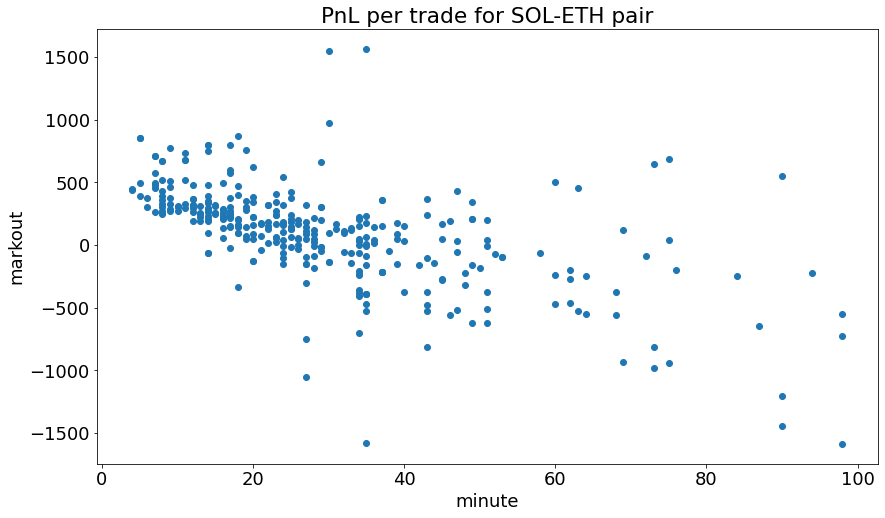

In [231]:
plt.scatter((res['converge_t'] - res['start']).apply(lambda x:x.total_seconds()/60), res['hgmk'])
plt.xlabel('minute')
plt.ylabel('markout')
plt.title('PnL per trade for SOL-ETH pair')

In [188]:
df1=pd.read_json('./Data/SOL_USDT-1m.json')
df1[0] = pd.to_datetime(df1[0], unit='ms')
df1.columns=['time', 'open', 'high', 'low', 'close', 'volume']
df1['id'] = 'SOL-USD'

In [194]:
df2=pd.read_json('./Data/ETH_USDT-1m.json')
df2[0] = pd.to_datetime(df2[0], unit='ms')
df2.columns=['time', 'open', 'high', 'low', 'close', 'volume']
df2['id'] = 'ETH-USD'

In [195]:
df_ = pd.concat([df1.set_index('time'), df2.set_index('time')])

In [196]:
df_

,open,high,low,close,volume,id
time,,,,,,
2022-01-01 00:00:00,170.01,170.22,169.93,170.14,810.2700,SOL-USD
2022-01-01 00:01:00,170.09,170.52,170.06,170.40,1504.7400,SOL-USD
2022-01-01 00:02:00,170.46,170.60,170.33,170.53,520.3000,SOL-USD
2022-01-01 00:03:00,170.53,170.60,170.27,170.34,1175.0300,SOL-USD
2022-01-01 00:04:00,170.33,170.49,170.31,170.40,318.9600,SOL-USD
...,...,...,...,...,...,...
2022-10-23 03:14:00,1313.05,1313.06,1313.04,1313.05,105.5113,ETH-USD
2022-10-23 03:15:00,1313.05,1313.06,1313.00,1313.01,79.1439,ETH-USD
2022-10-23 03:16:00,1313.02,1313.02,1313.01,1313.01,42.8751,ETH-USD
